# Figure 6

In [1]:
using DifferentialEquations
using LabelledArrays
using Parameters
using Setfield
using MitochondrialDynamics
import MitochondrialDynamics.Utils: second, μM, mV, mM, Hz, minute

# Plotting
import PyPlot as plt
rcParams = plt.PyDict(plt.matplotlib."rcParams")
rcParams["font.size"] = 14
rcParams["font.sans-serif"] = "Arial"
rcParams["font.family"] = "sans-serif"

"sans-serif"

In [2]:
glc = range(3.0mM, 30.0mM, length=301)

tend = 50minute

u0 = LVector(g3p = 2.8μM,
             pyr = 8.5μM,
             nadh_c = 1μM,
             nadh_m = 60μM,
             atp_c = 4000μM,
             adp_c = 500μM,
             ca_m = 0.250μM,
             dpsi = 100mV,
             x2 = 0.20,
             x3 = 0.05)

# Baseline parameters
param = MitoDynNode()

MitoDynNode{Float64}
  K_FISS: Float64 0.0016666666666666668
  K_FUSE: Float64 0.0016666666666666668
  R_FUSE23: Float64 0.5
  R_FISS23: Float64 1.5
  k_nadhc: Float64 0.1
  k_atp: Float64 0.04
  k_atp_ca: Float64 90.0
  k_g3p: Float64 0.01
  k_pyr: Float64 0.01
  Σa_c: Float64 4.5
  Σn_c: Float64 2.0
  gk: MitochondrialDynamics.GK{Float64}
  gpd: MitochondrialDynamics.GPD{Float64}
  ldh: MitochondrialDynamics.LDH{Float64}
  cai: MitochondrialDynamics.CaATP{Float64, Int64}
  adk: MitochondrialDynamics.AdK{Float64}
  k_nadhm: Float64 0.1
  Σn_m: Float64 2.2
  f1fo: MitochondrialDynamics.F1Fo{Float64}
  etc: MitochondrialDynamics.ETC{Float64}
  hleak: MitochondrialDynamics.HLeakExp{Float64}
  pdh: MitochondrialDynamics.PDH{Float64}
  nadht: MitochondrialDynamics.NADHT{Float64}
  mcu: MitochondrialDynamics.MCU{Float64}
  nclx: MitochondrialDynamics.NCLX{Float64}


In [3]:
# Diabetic Parameters
paramDM = let rPDH = 0.5, rETC = 0.75, rHL  = 1.4, rF1  = 0.5
    p = @set param.pdh.VMAX *= rPDH
    p = @set p.hleak.P_H *= rHL
    p = @set p.f1fo.VMAX *= rF1
    p = @set p.etc.VMAX *= rETC
end

function solve_ssens(param)
    ssprob = SteadyStateProblem(model!, u0, param)
    eprob =  EnsembleProblem(ssprob,prob_func=(prob, i, r) -> remake(prob, p=setglc(prob.p, glc[i])))
    esol = solve(eprob, DynamicSS(Rodas5(), tspan=tend), EnsembleThreads(), trajectories=length(glc))
    return esol
end

sim = solve_ssens(param)
simDM = solve_ssens(paramDM)

EnsembleSolution Solution of length 301 with uType:
SciMLBase.NonlinearSolution{_A, _B, _C, _D, SteadyStateProblem{LArray{Float64, 1, Vector{Float64}, (:g3p, :pyr, :nadh_c, :nadh_m, :atp_c, :adp_c, :ca_m, :dpsi, :x2, :x3)}, true, MitoDynNode{Float64}, ODEFunction{true, typeof(model!), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}}, DynamicSS{Rodas5{0, true, DefaultLinSolve, Val{:forward}}, Float64, Float64, Float64}, Nothing, Nothing} where {_A, _B, _C, _D}

In [4]:
function plot_cont!(ax, glc5, ys;
                    labels=["Baseline", "Diabetic"], ylabel="", xlabel="Glucose (X)", title="",
                    xlims=(), ylims=())
    ax.plot(glc5, ys)
    ax.legend(labels)
    ax.set(ylabel=ylabel, xlabel=xlabel)
    ax.set_title(title, loc="left")
    isempty(xlims) || ax.set_xlim(xlims...)
    isempty(ylims) || ax.set_ylim(ylims...)
    return ax
end

function plot_fig6(sim, simDM, glc, param; figsize=(20,10), glcscale=5.0)
    glc5    = glc ./ glcscale
    g3p     = [sim[1, :] simDM[1, :]]
    pyr     = [sim[2, :] simDM[2, :]]
    nadh_c  = [sim[3, :] simDM[3, :]]
    nadh_m  = [sim[4, :] simDM[4, :]]
    atp_c   = [sim[5, :] simDM[5, :]]
    adp_c   = [sim[6, :] simDM[6, :]]
    td      = atp_c ./ adp_c
    ca_m    = [sim[7, :] simDM[7, :]]
    dpsi    = [sim[8, :] simDM[8, :]]
    x2      = [sim[9, :] simDM[9, :]]
    x3      = [sim[10, :] simDM[10, :]]
    x1      = getx1.(x2, x3)
    ca_c    = param.cai.(adp_c, atp_c, nothing)
    avgDeg = avgdeg.(x2, x3, x1)
    x13 = x1 ./ x3

    # mM -> μM
    for arr in (g3p, pyr, nadh_c, nadh_m, atp_c, adp_c, ca_m, ca_c, dpsi)
        arr .*= 1000
    end

    fig, axs = plt.subplots(2, 4, figsize=figsize)

    plot_cont!(axs[1, 1], glc5, pyr, ylabel="Conc. (μM)", title="(A) Pyruvate")
    plot_cont!(axs[1, 2], glc5, nadh_c, ylabel="Conc. (μM)", title="(B) Cytosolic NADH")
    plot_cont!(axs[1, 3], glc5, nadh_m, ylabel="Conc. (μM)", title="(C) Mitochondrial NADH")
    plot_cont!(axs[1, 4], glc5, ca_c, ylabel="Conc. (μM)", title="(D) Cytosolic Ca")
    plot_cont!(axs[2, 1], glc5, ca_m, ylabel="Conc. (μM)", title="(E) Mitochondrial Ca")
    plot_cont!(axs[2, 2], glc5, dpsi, ylabel="ΔΨ (mV)", title="(F) ΔΨ")
    plot_cont!(axs[2, 3], glc5, td, title="(G) ATP:ADP")
    plot_cont!(axs[2, 4], glc5, avgDeg, title="(H) Average node degree")
    # plot_cont!(axs[3, 3], glc5, x13, ylabel="X1/X3 ratio", title="I")

    plt.tight_layout()
    return fig
end

plot_fig6 (generic function with 1 method)

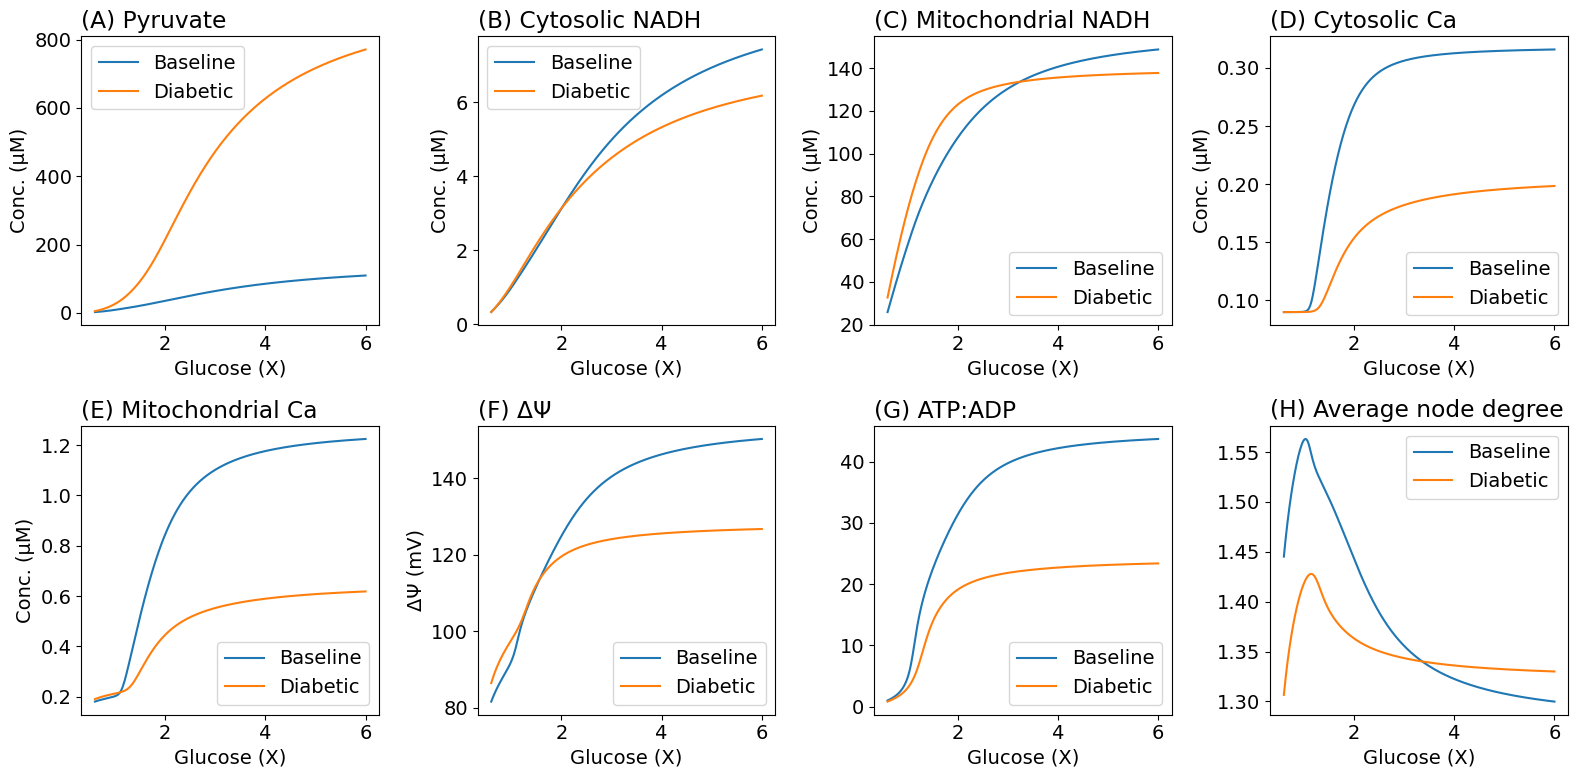

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/sosiristseng/.julia/packages/PyCall/3fwVL/src/numpy.jl:67
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


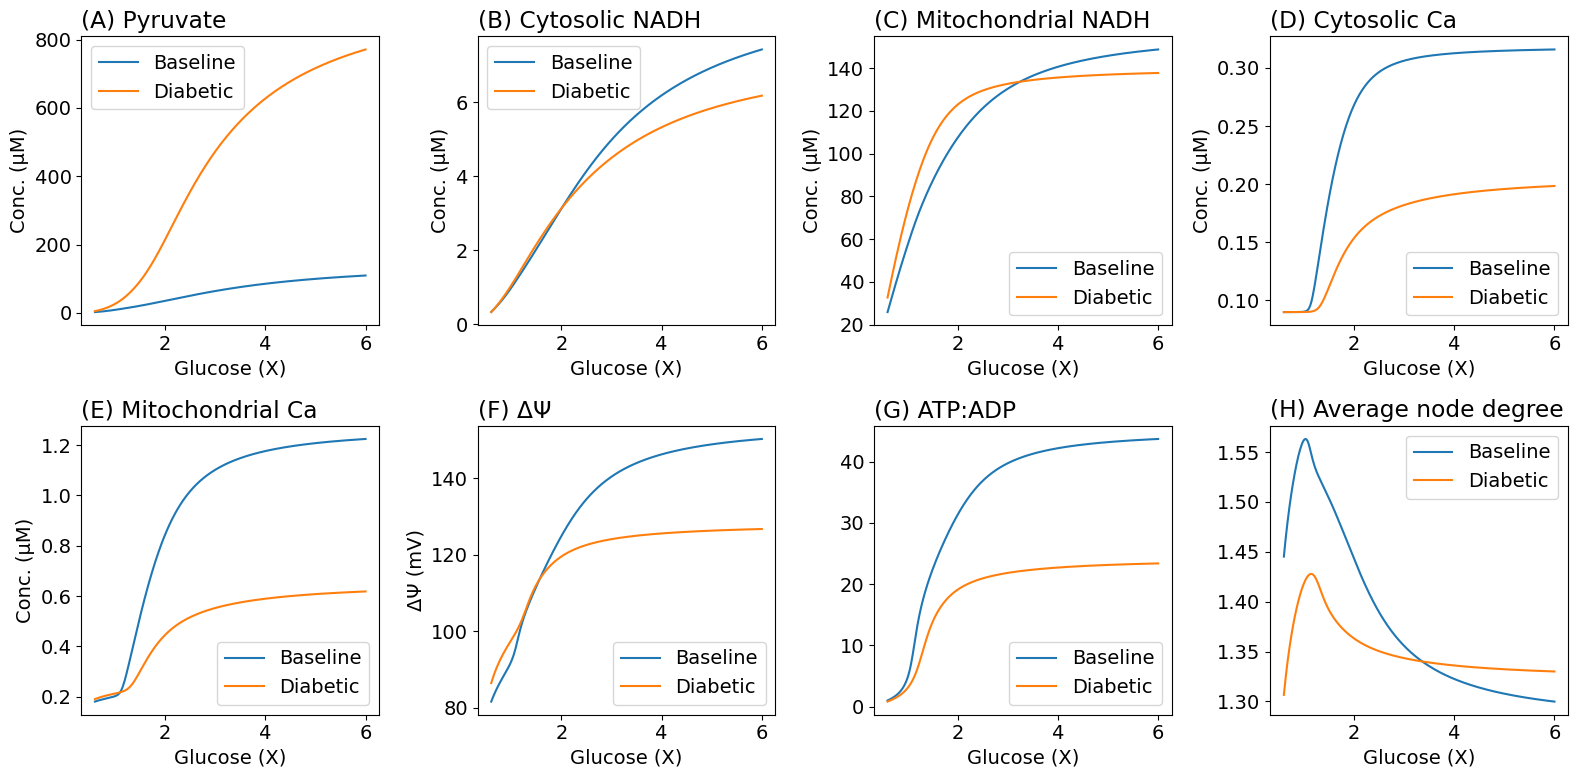

In [5]:
fig6 = plot_fig6(sim, simDM, glc, param,  figsize=(16,8))

In [ ]:
# Uncomment to generate pdf file
# fig6.savefig("Fig6.pdf")